In [150]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 

def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)

b = []

for i in range (100):
    data = run(['curl', ('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 5'"][i]-1000))+'-'+str(Data["Primary TSS, 5'"][i]+1000)+'.fasta/')], stdout=PIPE, stderr=PIPE, universal_newlines=True).stdout[:].replace('\n','')    
    b.append(data)
    if i % 1000 == 0: print(i)
    
#It took 106 minutes to comlpete all the sequences for 2.5 kb 

# 17 min for current states on 3000 only
#6000 took 36.15 min

0


In [157]:
Promoter_sequences = pd.DataFrame(b)

# Get all permutations of [1, 2, 3]
perm = ['A','C','G','T']
nucleotides = []

for p in range(1):
    for i in list(perm):
            for x in range(10):
                temp = '%s%s' % (x, i)
                nucleotides.append(temp)
    for z in range(len(Promoter_sequences)):
            for h in list(nucleotides):
                Promoter_sequences[0][z] = Promoter_sequences[0][z].replace(h,str((h[0],h[1])))
            if z % 1000 == 0:
                print(z)

Promoter_sequences[0] = Promoter_sequences[0].str.replace("'", "").str.replace(" ", "").str.replace("(", "").str.replace(")", "").str.replace(">hg19:", "")
Promoter_sequences = Promoter_sequences[0].str.split(",", expand = True)

Promoter_sequences[2] = Promoter_sequences.apply(lambda x: getKmers(x[1], 3), axis = 1)
Promoter_sequences = Promoter_sequences.drop(1, axis =1 )
Promoter_sequences = Promoter_sequences.drop(0, axis =1 )

Promoter_sequences[3] =  pd.DataFrame([1 if x != '[]' else 0 for x in Data['CpG_location']])

0


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_73672/2545878817.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Promoter_sequences[0] = Promoter_sequences[0].str.replace("'", "").str.replace(" ", "").str.replace("(", "").str.replace(")", "").str.replace(">hg19:", "")


In [161]:
Promoters_text = list(Promoter_sequences[2])
for item in range(len(Promoters_text)):
    Promoters_text[item] = ' '.join(Promoters_text[item])
y_data = Promoter_sequences.iloc[:, 1].values                         

In [164]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#cv = CountVectorizer(ngram_range=(3,100))
X = cv.fit_transform(Promoters_text)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size = 0.20, random_state=42)

print(X.shape)

(100, 64)


<AxesSubplot:>

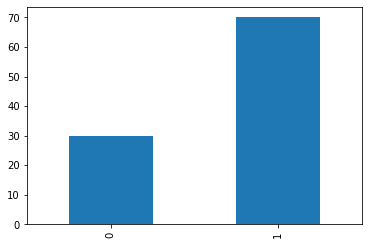

In [156]:
Promoter_sequences[3].value_counts().sort_index().plot.bar()

In [165]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [166]:
y_pred = classifier.predict(X_test)

In [167]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0   1
Actual          
0          7   0
1          0  13
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


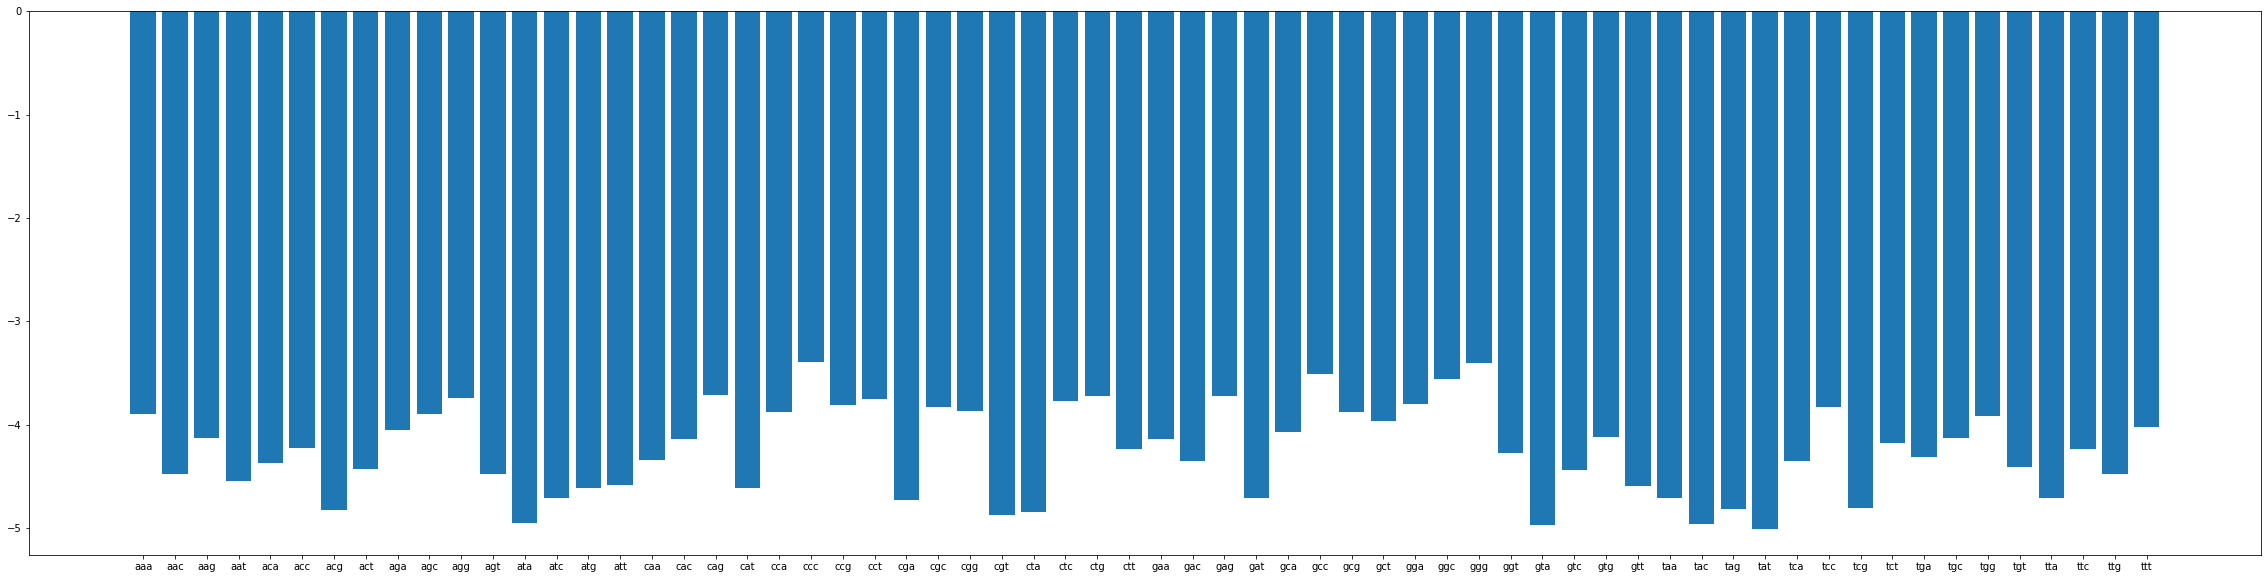

In [169]:
import matplotlib.pyplot as plt

weights = pd.DataFrame([cv.get_feature_names(), classifier.coef_[0]]).T

weights.sort_values(by = 1)

plt.bar(weights[0],weights[1])
plt.rcParams["figure.figsize"] = (40,10)
plt.show()


Genism, a Natural Language Processing Library for the Word2Vec algorithm

In [173]:
import gensim
from gensim.utils import simple_preprocess
Promoters_text = pd.DataFrame(Promoters_text, columns=['seq'])
Review_text = Promoters_text.seq.apply(simple_preprocess)

from gensim.models import Word2Vec

model = Word2Vec()
model.build_vocab(Review_text, progress_per=10)
model.train(Review_text, total_examples=model.corpus_count, epochs = model.epochs)

(312678, 999500)

In [176]:
model.wv.most_similar('cgc')
model.wv.similarity(w1 = "ccc", w2 = 'aaa')

-0.37417528